# Imports and Constants

In [1]:
import sys
# sys.path is a list of absolute path strings
sys.path.append('..')

import matplotlib.pyplot as plt
import math
import numpy as np
import os
import pandas as pd 
import pickle
import seaborn as sns 
from tqdm import tqdm

import rhythm_regression.vector_processing as vp
import rhythm_regression.notebook_tools as nbt
from generate_sample_matchings import RANDOM_SEED

DATA_DIR = '../data/matchings'
SAMPLE_SIZE = 10000

# Load Examples and Parameter Table

In [2]:
np.random.seed(RANDOM_SEED)

with open( "../data/matchings/example_set.pickle", "rb" ) as f:
    example_set = np.array(pickle.load(f), dtype=object)
    print(len(example_set))

parameter_table = pd.read_csv(os.path.join(DATA_DIR, 'generated_data_params.csv'), index_col=0)
parameter_table.index.name = 'example_id'

shuffle_permutation = np.random.permutation(len(example_set))
shuffled_example_set = example_set[shuffle_permutation]
shuffled_parameter_table = parameter_table.iloc[shuffle_permutation].reset_index(drop=False)

sample_examples = shuffled_example_set[0:SAMPLE_SIZE]
sample_parameter_table = shuffled_parameter_table[0:SAMPLE_SIZE]

sample_parameter_table.head()

484000


,example_id,deletion_rate,insertion_rate,len_m,space_augmentation_rate,space_reduction_rate
0,236351,0.04,0.3,300,0.003,0.005
1,433501,0.30,0.5,200,0.020,0.002
2,47864,0.00,0.5,300,0.010,0.003
3,32828,0.00,0.1,300,0.003,0.004
4,185363,0.03,0.3,100,0.050,0.002


# Generating Vector Statistics

In [3]:
rows = []

for example in tqdm(sample_examples):
   example['m_diff'] = np.diff(example['m'])
   example['t_diff'] = np.diff(example['t'])
   example['m_diff2'] = np.diff(example['m_diff'])
   example['t_diff2'] = np.diff(example['t_diff'])


   example['m_omega'] = max(example['m'])
   example['t_omega'] = max(example['t'])
   example['omega'] = max(example['m_omega'], example['t_omega'])
   example['len_t'] = len(example['t'])

   rows.append({key: example[key] for key in ['m_omega', 't_omega', 'omega', 'len_t']})

vector_stats = pd.DataFrame(rows)
vector_stats['example_id'] = sample_parameter_table['example_id']
vector_stats['len_m'] = sample_parameter_table['len_m']

def num_blocks(len_m, len_t):
   len_shorter_list = int(min(len_m, len_t))
   len_longer_list = int(max(len_m, len_t))
   return sum([(len_shorter_list - block_length + 1) * (len_longer_list - block_length + 1) 
               for block_length in range(1, len_shorter_list + 1)])
        
vector_stats['num_blocks'] = vector_stats.apply(lambda row: num_blocks(row['len_m'], row['len_t']), axis = 1) 

vector_stats.to_csv(os.path.join(DATA_DIR, 'vector_stats.csv'))

vector_stats

100%|██████████| 10000/10000 [00:00<00:00, 12012.35it/s]


,m_omega,t_omega,omega,len_t,example_id,len_m,num_blocks
0,139.291667,137.458449,139.291667,368,236351,300,12115250
1,82.875000,83.377490,83.377490,209,433501,200,2867600
2,125.708333,128.066143,128.066143,452,47864,300,15907850
3,129.291667,129.361210,129.361210,332,32828,300,10489850
4,49.708333,55.758226,55.758226,128,185363,100,479750
...,...,...,...,...,...,...,...
9995,41.041667,40.809296,41.041667,114,35293,100,409050
9996,45.083333,45.636648,45.636648,97,204572,100,323204
9997,45.041667,46.200516,46.200516,104,267495,100,358550
9998,74.583333,74.224951,74.583333,149,409260,200,1683700


In [11]:
print(vector_stats['num_blocks'].sum())
vector_stats.describe()

30355630019


,m_omega,t_omega,omega,len_t,example_id,len_m,num_blocks
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,1.000000e+04
mean,67.825117,68.264442,68.609288,161.488000,241476.09740,163.010000,3.035563e+06
std,40.715594,41.037455,41.165823,105.048219,140483.31512,96.442574,3.940646e+06
min,12.166667,11.501624,12.216369,17.000000,110.00000,50.000000,6.834000e+03
25%,29.916667,30.121458,30.121458,65.000000,120679.50000,100.000000,7.990000e+04
50%,64.666667,64.725665,64.901237,131.000000,239968.50000,200.000000,6.422050e+05
75%,109.343750,110.021252,110.791567,238.000000,364502.75000,300.000000,4.334900e+06
max,151.458333,158.605844,158.605844,461.000000,483962.00000,300.000000,1.631420e+07


<AxesSubplot: xlabel='num_blocks', ylabel='Count'>

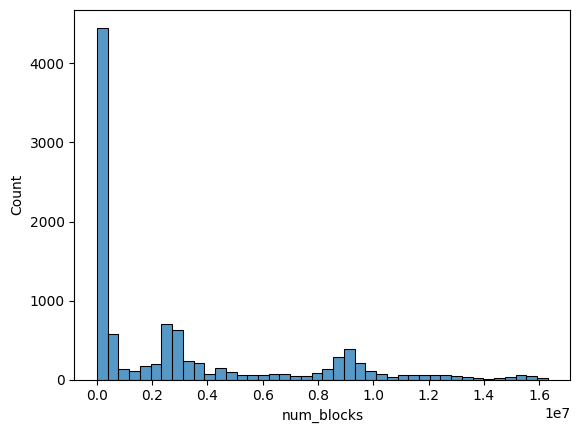

In [5]:
sns.histplot(vector_stats, x='num_blocks')

# Generate Blocks

In [6]:
MIN_BLOCK_SIZE = 1


def get_block_indices(len_m, len_t):

    len_smaller_list = min(len_m, len_t)
    len_larger_list = max(len_m, len_t)
    m_is_shorter = (len_m <= len_t)

    block_pairs = [(block1_start, block1_start + block_length, block2_start, block2_start + block_length) if m_is_shorter else \
                   (block2_start, block2_start + block_length, block1_start, block1_start + block_length)
                    for block_length in range(len_smaller_list, MIN_BLOCK_SIZE - 1, -1) \
                    for block1_start in range(0, len_smaller_list - block_length + 1) \
                    for block2_start in range(0, len_larger_list - block_length + 1) \
                    ] 

    return block_pairs


def validate_block_slices(len_m, len_t, m_start, m_end, t_start, t_end):

    if m_start < 0 or m_end < 0 or t_start < 0 or t_end < 0:
        raise ValueError(f'Cannot have negative indices.  Got indices {m_start} {m_end} {t_start} {t_end}')

    if m_start >= len_m or m_end > len_m:
        raise ValueError(f'One m index {m_start}, {m_end} is out of bounds in range [0, {len_m - 1}]. {len_m} {len_t} {t_start} {t_end}') 
    if t_start >= len_t or t_end > len_t:
        raise ValueError(f'One t index {t_start}, {t_end} is out of bounds in range [0, {len_t - 1}]') 

    if m_start >= m_end:
        raise ValueError(f'Starting m index must be less than ending m index.  Got indices {m_start} {m_end}')
    if t_start >= t_end:
        raise ValueError(f'Starting t index must be less than ending t index.  Got indices {t_start} {t_end}')

    if m_end - m_start != t_end - t_start:
        raise ValueError(f'Blocks are unequal sizes.  m block length is {m_end - m_start}.  t block length is {t_end - t_start}')

    if m_end - m_start < MIN_BLOCK_SIZE:
        raise ValueError(f'Block sizes must be at least {MIN_BLOCK_SIZE}.  Got block size {m_end - m_start}')


def true_is_block_match(matchings, m_start, m_end, t_start, t_end):
    """
    m_end and t_end are exclusive
    """

    mi = m_start
    ti = t_start

    while mi < m_end and ti < t_end:
        if (mi, ti) not in matchings:
            return False
        mi += 1
        ti += 1
    
    return True

In [7]:
assert(get_block_indices(5,3) == [
    (0,3,0,3), (1,4,0,3), (2,5,0,3), # block_length = 3
    (0,2,0,2), (1,3,0,2), (2,4,0,2), (3,5,0,2), (0,2,1,3), (1,3,1,3), (2,4,1,3), (3,5,1,3), # block_length = 2
    (0,1,0,1), (1,2,0,1), (2,3,0,1), (3,4,0,1), (4,5,0,1), (0,1,1,2), (1,2,1,2), (2,3,1,2), (3,4,1,2), (4,5,1,2), (0,1,2,3), (1,2,2,3), (2,3,2,3), (3,4,2,3), (4,5,2,3), # block_length = 1
    ]
)

assert(get_block_indices(3,5) == [
    (0,3,0,3), (0,3,1,4), (0,3,2,5), # block_length = 3
    (0,2,0,2), (0,2,1,3), (0,2,2,4), (0,2,3,5), (1,3,0,2), (1,3,1,3), (1,3,2,4), (1,3,3,5), # block_length = 2
    (0,1,0,1), (0,1,1,2), (0,1,2,3), (0,1,3,4), (0,1,4,5), (1,2,0,1), (1,2,1,2), (1,2,2,3), (1,2,3,4), (1,2,4,5), (2,3,0,1), (2,3,1,2), (2,3,2,3), (2,3,3,4), (2,3,4,5), # block_length = 1
    ]
)

assert(get_block_indices(3,3) == [
    (0,3,0,3), # block_length = 3
    (0,2,0,2), (0,2,1,3), (1,3,0,2), (1,3,1,3), # block_length = 2
    (0,1,0,1), (0,1,1,2), (0,1,2,3), (1,2,0,1), (1,2,1,2), (1,2,2,3), (2,3,0,1), (2,3,1,2), (2,3,2,3) # block_length = 1
    ]
)

# Generate Block Statistics

In [8]:
def compute_block_statistics(example, m_start, m_end, t_start, t_end):

    validate_block_slices(len(example['m']), len(example['t']), m_start, m_end, t_start, t_end)
    
    stats = {}

    m_block = example['m'][m_start : m_end]
    t_block = example['t'][t_start : t_end]
    m_diff_block = example['m_diff'][m_start : m_end - 1]
    t_diff_block = example['t_diff'][t_start : t_end - 1]
    m_diff2_block = example['m_diff2'][m_start : m_end - 2]
    t_diff2_block = example['t_diff2'][t_start : t_end - 2]

    block_length = m_end - m_start

    if block_length > 0:
        stats['total_timestamp_residual'] = np.sum(np.abs(m_block - t_block))
        stats['mean_timestamp_residual'] = stats['total_timestamp_residual'] / block_length

    if block_length > 1:
        stats['total_rhythm_residual'] = np.sum(np.abs(m_diff_block - t_diff_block))
        stats['mean_rhythm_residual'] = stats['total_rhythm_residual'] / block_length

    if block_length > 2:
        stats['total_accel_residual'] = np.sum(np.abs(m_diff2_block - t_diff2_block))
        stats['mean_accel_residual'] = stats['total_accel_residual'] / block_length

    return stats 


In [107]:
def get_num_blocks_of_length(length, len_m, len_t):

    len_smaller_list = min(len_m, len_t)
    len_larger_list = max(len_m, len_t)

    if length > len_smaller_list or length < MIN_BLOCK_SIZE:
        return 0

    return (len_smaller_list - length + 1) * (len_larger_list - length + 1)


# Do we want to randomly sample blocks according to their block length, e.g. smaller blocks are sampled more often because there are more
# OR do we want to upsample the large blocks e.g. choose a block length uniformly and then choose a block
def sample_blocks(num_blocks, len_m, len_t, upsample_large_blocks = False):

    len_smaller_list = min(len_m, len_t)
    len_larger_list = max(len_m, len_t)
    m_is_shorter = (len_m <= len_t)

    # randomly select block lengths
    block_length_options = list(range(MIN_BLOCK_SIZE, len_smaller_list + 1))
    if upsample_large_blocks:
        block_length_pmf = None # default from numpy is a uniform distribution over block lengths
    else:
        block_length_pmf = np.array([get_num_blocks_of_length(length, len_m, len_t) for length in block_length_options])
        block_length_pmf = block_length_pmf / block_length_pmf.sum()

    block_lengths = np.random.choice(block_length_options, 
                                    size=num_blocks,
                                    replace=True, 
                                    p=block_length_pmf)

    # select a pattern of that block length
    pattern_start_options = [list(range(0, len_smaller_list - block_length + 1)) for block_length in block_lengths]
    pattern_starts = np.array([np.random.choice(options, size=1) for options in pattern_start_options]).flatten()

    # select a test region of that block length
    test_start_options = [list(range(0, len_larger_list - block_length + 1)) for block_length in block_lengths]
    test_starts = np.array([np.random.choice(options, size=1) for options in test_start_options]).flatten()

    # select blocks
    blocks = []
    for i in range(len(block_lengths)):
        block1_start, block1_end = pattern_starts[i], pattern_starts[i] + block_lengths[i]
        block2_start, block2_end = test_starts[i], test_starts[i] + block_lengths[i]

        new_block = (block1_start, block1_end, block2_start, block2_end) if m_is_shorter else \
                    (block2_start, block2_end, block1_start, block1_end)

        validate_block_slices(len_m, len_t, new_block[0], new_block[1], new_block[2], new_block[3])
        blocks.append(new_block)

    return blocks

In [108]:
sample_blocks(50, 30, 300)

[(8, 29, 15, 36),
 (8, 18, 227, 237),
 (0, 30, 9, 39),
 (10, 14, 213, 217),
 (25, 29, 267, 271),
 (11, 14, 71, 74),
 (9, 28, 206, 225),
 (12, 13, 53, 54),
 (14, 25, 188, 199),
 (12, 20, 127, 135),
 (2, 23, 137, 158),
 (4, 9, 103, 108),
 (11, 26, 91, 106),
 (16, 23, 258, 265),
 (21, 25, 238, 242),
 (5, 20, 220, 235),
 (13, 22, 146, 155),
 (11, 29, 188, 206),
 (1, 17, 48, 64),
 (10, 22, 241, 253),
 (24, 29, 38, 43),
 (1, 18, 125, 142),
 (12, 14, 239, 241),
 (7, 22, 138, 153),
 (3, 10, 287, 294),
 (26, 29, 104, 107),
 (9, 15, 171, 177),
 (4, 16, 73, 85),
 (4, 7, 178, 181),
 (0, 22, 4, 26),
 (7, 11, 266, 270),
 (17, 28, 75, 86),
 (19, 26, 35, 42),
 (8, 27, 256, 275),
 (16, 17, 182, 183),
 (5, 30, 0, 25),
 (26, 30, 80, 84),
 (9, 14, 225, 230),
 (18, 19, 230, 231),
 (0, 3, 210, 213),
 (3, 22, 117, 136),
 (10, 22, 238, 250),
 (4, 5, 198, 199),
 (8, 13, 105, 110),
 (2, 14, 194, 206),
 (9, 16, 193, 200),
 (19, 20, 7, 8),
 (13, 22, 245, 254),
 (5, 14, 197, 206),
 (0, 6, 145, 151)]

In [133]:
BLOCK_SAMPLE_RATE = 1000  # sample 10000 blocks per example

np.random.seed(RANDOM_SEED)

rows = []

for i, example in enumerate(tqdm(sample_examples, desc='example')):
#for i, example in enumerate(sample_examples):

    #block_pairs = get_block_indices(len(example['m']), len(example['t']))
    blocks = sample_blocks(BLOCK_SAMPLE_RATE, len(example['m']), len(example['t']), upsample_large_blocks=False)
    
    #for m_start, m_end, t_start, t_end in tqdm(blocks, desc='block', leave=False):
    for m_start, m_end, t_start, t_end in blocks:

            stats = compute_block_statistics(example, m_start, m_end, t_start, t_end)

            new_row = {'example_id': i,
                    'm_start': m_start, 
                    'm_end': m_end, 
                    't_start': t_start, 
                    't_end': t_end, 
                    'true_is_block_match': int(true_is_block_match(example['matchings'], 
                                                                m_start, 
                                                                m_end, 
                                                                t_start, 
                                                                t_end)),
                    } | \
                    stats

            rows.append(new_row)

block_stats = pd.DataFrame(rows)
block_stats['block_length'] = block_stats['m_end'] - block_stats['m_start']

block_stats.to_csv(os.path.join(DATA_DIR, 'block_stats.csv'))

block_stats

example: 100%|██████████| 10000/10000 [13:57<00:00, 11.94it/s]


,example_id,m_start,m_end,t_start,t_end,true_is_block_match,total_timestamp_residual,mean_timestamp_residual,total_rhythm_residual,mean_rhythm_residual,total_accel_residual,mean_accel_residual,block_length
0,0,81,223,100,242,0,900.707064,6.343007,57.230573,0.403032,84.109304,0.592319,142
1,0,87,169,237,319,0,3134.525947,38.225926,39.148596,0.477422,57.657363,0.703139,82
2,0,102,210,213,321,0,2526.229505,23.391014,47.071887,0.435851,65.540937,0.606861,108
3,0,99,119,210,230,0,495.584104,24.779205,8.772413,0.438621,11.344362,0.567218,20
4,0,149,239,105,195,0,2604.201862,28.935576,32.367616,0.359640,45.929116,0.510324,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999995,9999,11,69,30,88,0,577.691850,9.960204,28.948986,0.499120,51.845275,0.893884,58
9999996,9999,79,89,7,17,0,324.994270,32.499427,3.486946,0.348695,5.561995,0.556199,10
9999997,9999,36,97,5,66,0,833.652506,13.666435,27.434058,0.449739,48.877802,0.801275,61
9999998,9999,25,42,75,92,0,435.865999,25.639176,7.861192,0.462423,12.061297,0.709488,17


In [150]:
#block_stats['m_start%'] = block_stats['m_start'] / block_stats['len_m']
#block_stats['t_start%'] = block_stats['t_start'] / block_stats['len_t']
#block_stats['m_end%'] = block_stats['m_end'] / block_stats['len_m']
#block_stats['t_end%'] = block_stats['t_end'] / block_stats['len_t']
#block_stats['block_length%m'] = block_stats['block_length'] / block_stats['len_m']
#block_stats['block_length%t'] = block_stats['block_length'] / block_stats['len_t']
block_stats['index_distance'] = (block_stats['m_start'] - block_stats['t_start']).abs()
block_stats['relative_distance'] = block_stats['index_distance'] / block_stats['block_length']
block_stats

,example_id,m_start,m_end,t_start,t_end,true_is_block_match,total_timestamp_residual,mean_timestamp_residual,total_rhythm_residual,mean_rhythm_residual,total_accel_residual,mean_accel_residual,block_length,index_distance,relative_distance
0,0,81,223,100,242,0,900.707064,6.343007,57.230573,0.403032,84.109304,0.592319,142,19,0.133803
1,0,87,169,237,319,0,3134.525947,38.225926,39.148596,0.477422,57.657363,0.703139,82,150,1.829268
2,0,102,210,213,321,0,2526.229505,23.391014,47.071887,0.435851,65.540937,0.606861,108,111,1.027778
3,0,99,119,210,230,0,495.584104,24.779205,8.772413,0.438621,11.344362,0.567218,20,111,5.550000
4,0,149,239,105,195,0,2604.201862,28.935576,32.367616,0.359640,45.929116,0.510324,90,44,0.488889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999995,9999,11,69,30,88,0,577.691850,9.960204,28.948986,0.499120,51.845275,0.893884,58,19,0.327586
9999996,9999,79,89,7,17,0,324.994270,32.499427,3.486946,0.348695,5.561995,0.556199,10,72,7.200000
9999997,9999,36,97,5,66,0,833.652506,13.666435,27.434058,0.449739,48.877802,0.801275,61,31,0.508197
9999998,9999,25,42,75,92,0,435.865999,25.639176,7.861192,0.462423,12.061297,0.709488,17,50,2.941176


# EDA

In [154]:
block_stats.describe()

,example_id,m_start,m_end,t_start,t_end,true_is_block_match,total_timestamp_residual,mean_timestamp_residual,total_rhythm_residual,mean_rhythm_residual,total_accel_residual,mean_accel_residual,block_length,index_distance,relative_distance
count,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,9.703986e+06,9.703986e+06,9.416585e+06,9.416585e+06,1.000000e+07,1.000000e+07,1.000000e+07
mean,4.999500e+03,6.149613e+01,1.015074e+02,6.073611e+01,1.007474e+02,3.024400e-03,7.620594e+02,1.742005e+01,1.728655e+01,4.046735e-01,2.652542e+01,5.807732e-01,4.001124e+01,4.424095e+01,3.999563e+00
std,2.886751e+03,5.915517e+01,7.582305e+01,6.234474e+01,7.983255e+01,5.491132e-02,1.242175e+03,1.862170e+01,1.857823e+01,1.551761e-01,2.851229e+01,2.226005e-01,4.303778e+01,4.746601e+01,1.128828e+01
min,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.174686e-06,2.724895e-06,1.000000e+00,0.000000e+00,0.000000e+00
25%,2.499750e+03,1.800000e+01,4.000000e+01,1.600000e+01,3.800000e+01,0.000000e+00,5.738576e+01,4.374266e+00,4.189998e+00,3.226351e-01,6.342090e+00,4.563275e-01,1.000000e+01,1.100000e+01,3.846154e-01
50%,4.999500e+03,4.000000e+01,7.900000e+01,3.800000e+01,7.600000e+01,0.000000e+00,2.222571e+02,1.064803e+01,1.055895e+01,3.978035e-01,1.621847e+01,5.835437e-01,2.400000e+01,2.700000e+01,1.100000e+00
75%,7.499250e+03,8.700000e+01,1.550000e+02,8.500000e+01,1.480000e+02,0.000000e+00,8.839783e+02,2.386643e+01,2.387743e+01,4.761065e-01,3.676723e+01,7.019136e-01,5.500000e+01,6.100000e+01,3.125000e+00
max,9.999000e+03,2.990000e+02,3.000000e+02,4.550000e+02,4.610000e+02,1.000000e+00,1.290633e+04,1.520282e+02,1.466330e+02,4.639728e+00,2.370794e+02,4.943409e+00,3.000000e+02,4.380000e+02,4.290000e+02


<AxesSubplot: xlabel='relative_distance', ylabel='Count'>

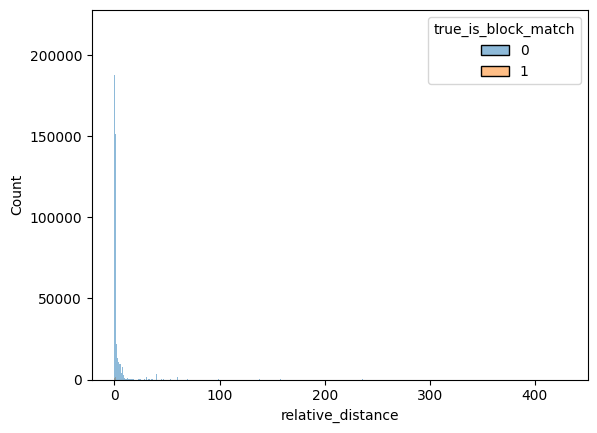

In [151]:
sns.histplot(block_stats, x='relative_distance', hue='true_is_block_match')

<AxesSubplot: xlabel='block_length', ylabel='Count'>

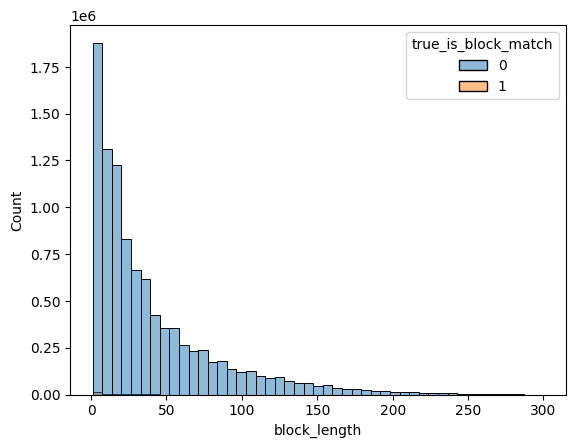

In [135]:
sns.histplot(block_stats, x='block_length', hue='true_is_block_match', bins=47)

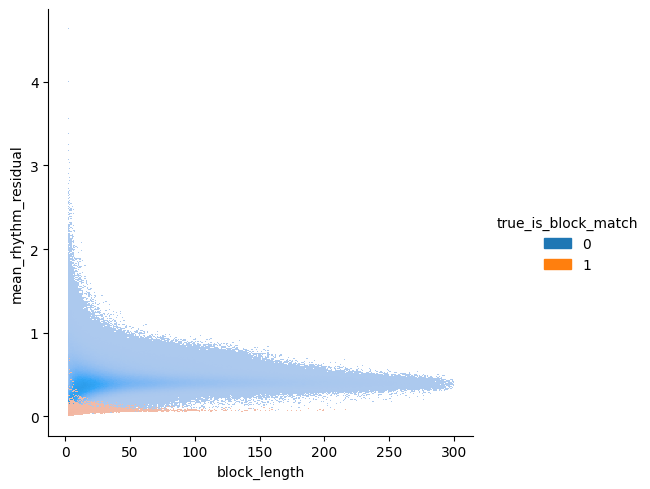

In [139]:
sns.displot(block_stats, x="block_length", y="mean_rhythm_residual", hue='true_is_block_match', binwidth=(1, 0.005))

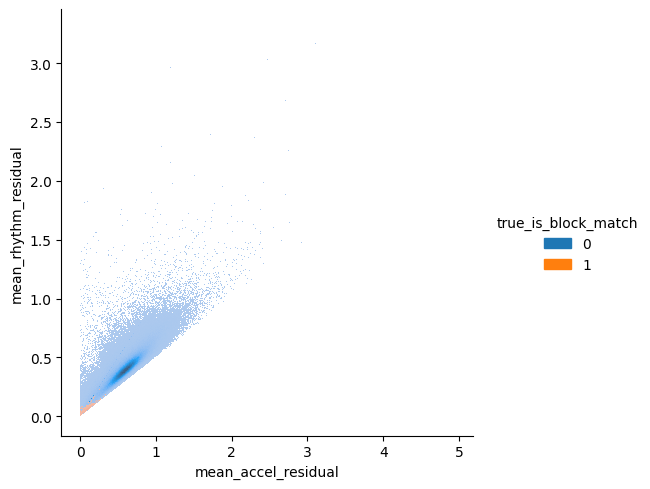

In [140]:
sns.displot(block_stats, x="mean_accel_residual", y="mean_rhythm_residual", hue='true_is_block_match')

In [155]:
block_stats.groupby('true_is_block_match')['relative_distance'].describe()

# I think my predictors will be mean_accel_residual, mean_rhythm_residual, and block_length

,count,mean,std,min,25%,50%,75%,max
true_is_block_match,,,,,,,,
0,9969756.0,4.007892,11.301472,0.0,0.386667,1.103448,3.131148,429.0
1,30244.0,1.253928,4.648003,0.0,0.000000,0.071429,0.500000,150.0


<AxesSubplot: >

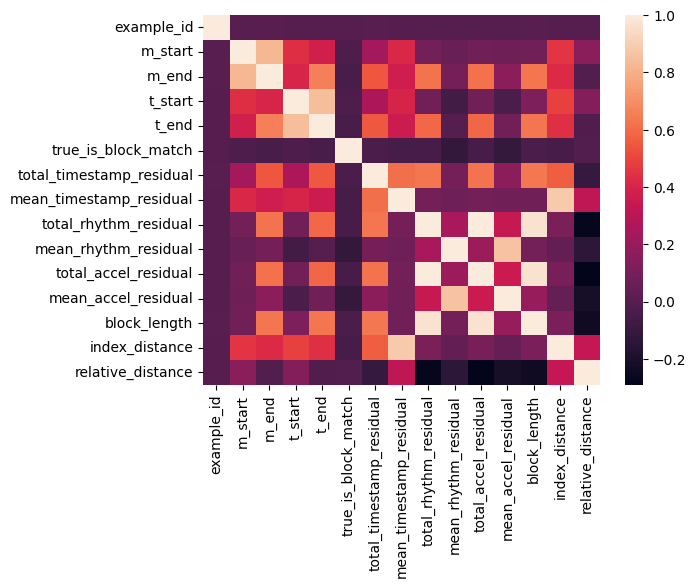

In [156]:
sns.heatmap(block_stats.corr())

# Greedy Block Algorithm

In [158]:
def greedy_block_match(example):
    block_pairs = get_block_indices(len(example['m']), len(example['t']))
    free_m_indices = set(range(len(example['m'])))
    free_t_indices = set(range(len(example['t'])))

    matchings = []
    blocks = []

    for m_start, m_end, t_start, t_end in tqdm(block_pairs):

        # if block is a match
        if true_is_block_match(example['matchings'], m_start, m_end, t_start, t_end):

            # if blocks are free to claim
            if set(range(m_start, m_end)) <= free_m_indices and set(range(t_start, t_end)) <= free_t_indices:

                # claim the block and add it to matchings
                free_m_indices -= set(range(m_start, m_end))
                free_t_indices -= set(range(t_start, t_end))

                blocks.append((m_start, m_end, t_start, t_end))

                mi = m_start
                ti = t_start
                while mi < m_end and ti < t_end:
                    matchings.append((mi, ti))
                    mi += 1 
                    ti += 1

                if len(free_m_indices) == 0 and len(free_t_indices) == 0:
                    print('Brekaing! All done here!')
                    break

    # deletion of notes
    for mi in free_m_indices:
        matchings.append((mi, None))

    # insertion of notes
    for ti in free_t_indices:
        matchings.append((None, ti))

    matchings.sort(key=lambda tup: tup[0] if tup[0] is not None else tup[1])
    vp.validate_matching(example['m'], example['t'], matchings)

    #return matchings, blocks, free_m_indices, free_t_indices
    return matchings


In [ ]:
parameter_table[ \
    (parameter_table['deletion_rate'] == 0.1) & \
    (parameter_table['insertion_rate'] == 0) & \
    (parameter_table['space_augmentation_rate'] == 0) & \
    (parameter_table['space_reduction_rate'] == 0) & \
    (parameter_table['len_m'] == 300)
]

In [ ]:
#matchings, blocks, free_m, free_t = greedy_block_match(sample_examples[0])
matchings, blocks, free_m, free_t = greedy_block_match(example_set[294030])
print(matchings)
print(blocks)
print(len(blocks))
print(free_m)
print(free_t)

#vp.score_matching(matchings, sample_examples[0]['matchings'])
vp.score_matching(matchings, example_set[294030]['matchings'])

In [161]:
scores = [vp.score_matching(greedy_block_match(example), example['matchings']) for example in sample_examples[0:100]]
print(scores)
np.mean(scores)

  0%|          | 0/42925 [00:00<?, ?it/s]


Brekaing! All done here!


  0%|          | 0/338350 [00:00<?, ?it/s]


Brekaing! All done here!


  0%|          | 0/42925 [00:00<?, ?it/s]


Brekaing! All done here!


100%|██████████| 318160/318160 [00:00<00:00, 382617.64it/s]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


1.0

In [ ]:
#example = example_set[294030]
#nbt.plot_matching_in_rows(example['m'], example['t'], example['matchings'])

In [ ]:
#set(sample_examples[0]['matchings']) - set(matchings)
set(example_set[294030]['matchings']) - set(matchings)

In [ ]:
#set(matchings) - set(sample_examples[0]['matchings'])
set(matchings) - set(example_set[294030]['matchings'])

## Summary of Ideas so far

**Good Strategies**
- Snapping
- `np.isclose()`
- Differencing to get rhythm vectors
- Normalizing those rhythm vectors by dividing by a reference rhythm. Good candidates include
    - Quarter note length in seconds computed from MIDI observed tempo
    - The first note of t and m
    - The first note of m
    - The first note of a pattern.  Patterns are local
- Abstract away tempo by normalizing the timestamps (or rhythms, idk)
    - Every input to my algorithm should be normalized to be the same tempo.  They way I can decide thresholds for things without having to worry about if the thresholds change as tempo does.  WAIT NO THIS DOESN'T WORK.  A 32nd note of difference might be acceptable at 168, but not at 60 bpm.

**Requirements**
- Pre Matching
    - Match together extended sections of rhythms which are the same.

**Strategies to test**
- Give a score for a match, not a boolean
    - We want to score longer matches higher?
    - Perhaps there's a threshold
- Tempo invariant matching (normalization)
    - Requires a minimum of two rhythms (3 notes)
- I bet we can write the log_t_diff distribution as a Guassian Mixture Model, where the means are the unique(log(m_diff))